In [1]:
library('tidyverse')
library('tidyr')
library('ggplot2')
library('Amelia')
library("e1071")
library('GGally')
library('ggExtra')
library("plot3D")

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'Amelia' was built under R version 3.6.1"
Loading required package: Rcpp

## 
## Amelia II: Multipl

In [2]:
data <- read.csv('Du lieu cung cap/children_lung.csv')

In [3]:
head(data)

,age,FEV,ht,sex,smoke
,<dbl>,<dbl>,<dbl>,<int>,<int>
1,9,1.708,57.0,0,0
2,8,1.724,67.5,0,0
3,7,1.720,54.5,0,0
4,9,1.558,53.0,1,0
5,9,1.895,57.0,1,0
6,8,2.336,61.0,0,0


In [4]:
print(paste('nrows: ',nrow(data)))
print(paste('ncols: ',ncol(data)))

[1] "nrows:  654"
[1] "ncols:  5"


In [5]:
summary(data)

      age             FEV               ht             sex        
 Min.   :1.458   Min.   : 0.791   Min.   :46.00   Min.   :0.0000  
 1st Qu.:3.049   1st Qu.: 2.041   1st Qu.:53.50   1st Qu.:0.0000  
 Median :4.330   Median :59.000   Median :57.00   Median :0.0000  
 Mean   :5.205   Mean   :35.210   Mean   :56.92   Mean   :0.4984  
 3rd Qu.:8.000   3rd Qu.:65.000   3rd Qu.:60.00   3rd Qu.:1.0000  
 Max.   :9.000   Max.   :74.000   Max.   :69.00   Max.   :1.0000  
                                  NA's   :345     NA's   :345     
     smoke       
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.0032  
 3rd Qu.:0.0000  
 Max.   :1.0000  
 NA's   :345     

In [6]:
str(data)

'data.frame':	654 obs. of  5 variables:
 $ age  : num  9 8 7 9 9 8 6 6 8 9 ...
 $ FEV  : num  1.71 1.72 1.72 1.56 1.9 ...
 $ ht   : num  57 67.5 54.5 53 57 61 58 56 58.5 60 ...
 $ sex  : int  0 0 0 1 1 0 0 0 0 0 ...
 $ smoke: int  0 0 0 0 0 0 0 0 0 0 ...


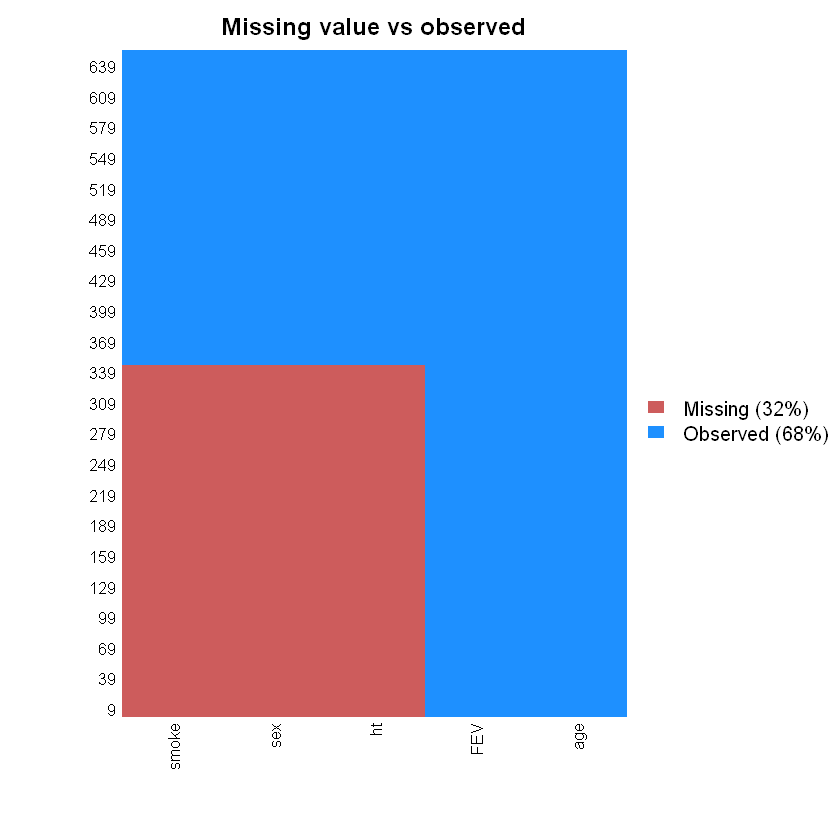

In [7]:
#3.
missmap(data, main='Missing value vs observed')

- Dữ liệu thiếu ở các cột Sex, Smoke là các giá trị nhị phân (0,1) không thể thay thế được
- Chỉ thay thế missing value tại cột ht, bằng giá trị median bỏ số lượng mẫu nhỏ và không chịu ảnh hưởng bới Outliers

In [8]:
missing <- colSums(is.na(data))[colSums(is.na(data))>0]
print(missing)
missing <- as.data.frame(missing)
missing$missing_percentage <- round(missing/sum(is.na(data)),2)
colnames(missing) <- c('count_missings','missing_percentage')
print('**********************************************')
print(missing)

   ht   sex smoke 
  345   345   345 
[1] "**********************************************"
      count_missings missing
ht               345    0.33
sex              345    0.33
smoke            345    0.33


In [9]:
print('Before replace NAs: ')
print(summary(data$ht))
data$ht[is.na(data$ht)] <- median(data$ht, na.rm=TRUE)
print('After replace NAs with median ')
print(summary(data$ht))

[1] "Before replace NAs: "
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  46.00   53.50   57.00   56.92   60.00   69.00     345 
[1] "After replace NAs with median "
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  46.00   57.00   57.00   56.96   57.00   69.00 


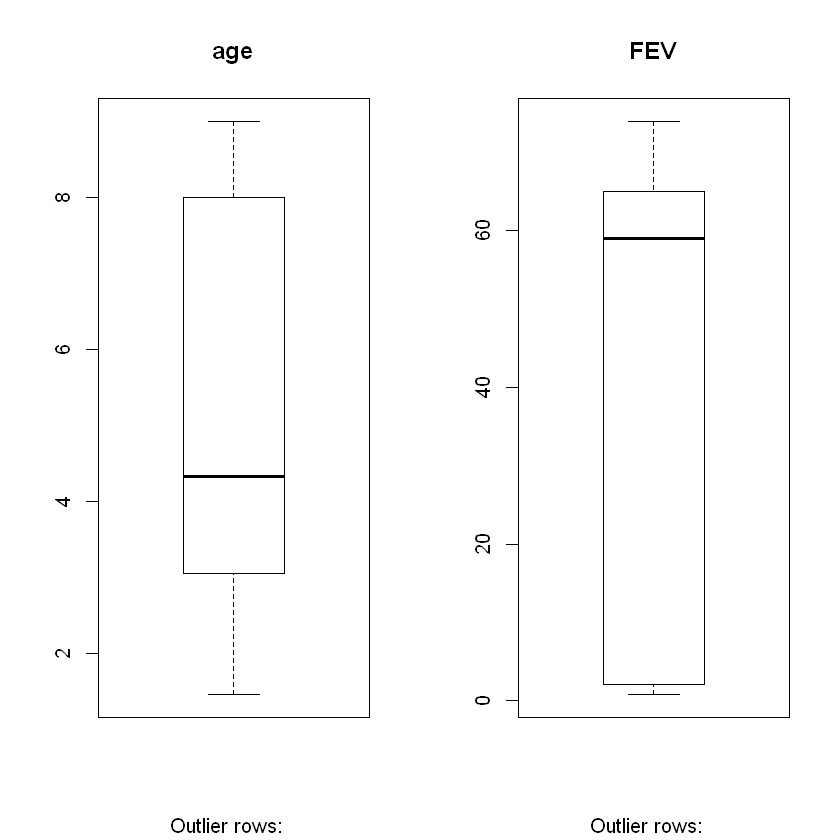

In [10]:
par(mfrow=c(1,2))
boxplot(data$age, main='age', 
  sub=paste('Outlier rows: ',toString(boxplot.stats(data$age)$out)))
boxplot(data$FEV, main='FEV', 
  sub=paste('Outlier rows: ',toString(boxplot.stats(data$FEV)$out)))
# boxplot(data$ht, main='ht', 
#   sub=paste('Outlier rows: ',toString(boxplot.stats(data$ht)$out)))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



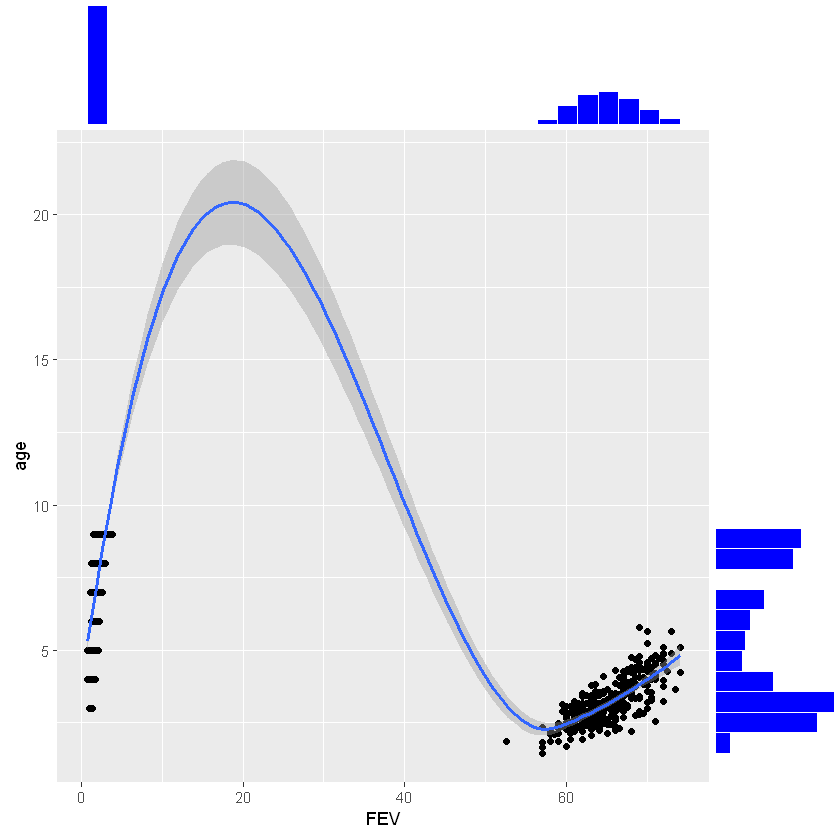

In [11]:
#4. FEV & Age
# 11.
library('ggExtra')
plot <- ggplot(data,aes(x=FEV, y=age)) + geom_point() + geom_smooth() 
ggMarginal(plot, type='hist', col='white', fill='blue')

- Có sự phân cách rất rõ của FEV<10 và FEV>50
- Chia dữ liệu 2 phần để phân tích

In [12]:
#5. 
data_FEV_more_10 <- data %>% subset(FEV >10)
data_FEV_less_10 <- data %>% subset(FEV <10)

In [13]:
cor(data_FEV_more_10$age, data_FEV_more_10$FEV)

[1] 0.7607791

In [14]:
# 6
set.seed(0) #
trainingRowIndex <- sample(1:nrow(data_FEV_more_10), 0.8*nrow(data_FEV_more_10),replace=F)
# print(trainingRowIndex)
trainingData <- data_FEV_more_10[trainingRowIndex,]
testData <- data_FEV_more_10[-trainingRowIndex,]
print(nrow(trainingData))
print(nrow(testData))

[1] 276
[1] 69


In [15]:
lmMod <- lm(FEV~ age, data=trainingData)
lmMod


Call:
lm(formula = FEV ~ age, data = trainingData)

Coefficients:
(Intercept)          age  
     53.115        3.703  


In [16]:
iPred <- predict(lmMod, testData)

In [17]:
mse <- mean(lmMod$residuals^2)
print(paste('mse train: ',mse))

[1] "mse train:  5.88209602355006"


In [18]:
mse_test <- mean((testData$FEV - iPred)^2)
print(paste('mse in test: ',mse_test))

[1] "mse in test:  5.90859881589691"


In [19]:
iPred_train <- predict(lmMod, trainingData)
rsquare_train <- 1- sum((trainingData$FEV - iPred_train)^2)/
 sum((trainingData$FEV - mean(trainingData$FEV))^2)
rsquare_train

[1] 0.5650784

In [20]:
rsquare_test <- 1- sum((testData$FEV - iPred)^2) /sum((testData$FEV - mean(testData$FEV))^2)
rsquare_test

[1] 0.6226758

# Simple Linear Regression predict FEV ~ age : 62.3%

In [21]:
print(coef(lmMod))
beta_width <- coef(lmMod)['age']
intercept <- coef(lmMod)['(Intercept)']

(Intercept)         age 
  53.115086    3.703441 


In [22]:
age_new <- c(2,3,4,5)
FEV_new <- intercept + beta_width*age_new
print(FEV_new)

[1] 60.52197 64.22541 67.92885 71.63229


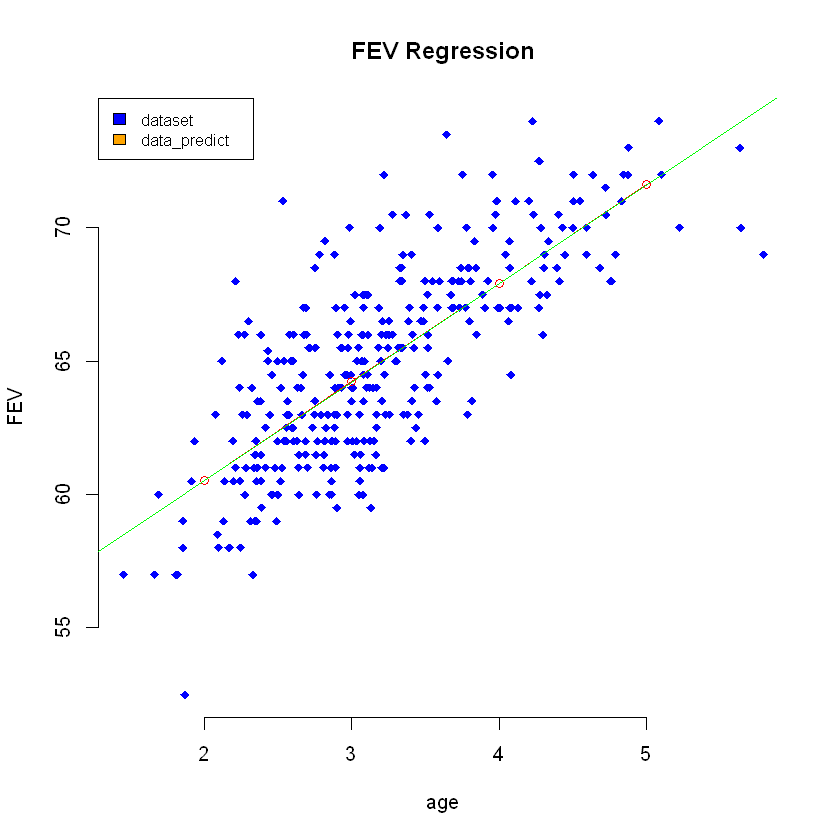

In [23]:
plot(data_FEV_more_10$age, data_FEV_more_10$FEV,
  main='FEV Regression',
  xlab='age', ylab='FEV',
  pch=18, frame=FALSE, col='blue')
lines(age_new, FEV_new, col='red',type='o')
abline(lmMod, data_FEV_more_10, col='green')
legend('topleft', c('dataset','data_predict'), 
  cex=0.8, fill=c('blue','orange'))

- Model dự doán khá tốt

In [24]:
#7.
head(data_FEV_less_10)

,age,FEV,ht,sex,smoke
,<dbl>,<dbl>,<dbl>,<int>,<int>
1,9,1.708,57.0,0,0
2,8,1.724,67.5,0,0
3,7,1.720,54.5,0,0
4,9,1.558,53.0,1,0
5,9,1.895,57.0,1,0
6,8,2.336,61.0,0,0


In [25]:
set.seed(0) #
trainingRowIndex <- sample(1:nrow(data_FEV_less_10), 0.8*nrow(data_FEV_less_10),replace=F)
# print(trainingRowIndex)
trainingData <- data_FEV_less_10[trainingRowIndex,]
testData <- data_FEV_less_10[-trainingRowIndex,]
print(nrow(trainingData))
print(nrow(testData))

[1] 247
[1] 62


In [26]:
lmMod <- lm(FEV~age+ht, data=trainingData)
lmMod


Call:
lm(formula = FEV ~ age + ht, data = trainingData)

Coefficients:
(Intercept)          age           ht  
   -3.33869      0.01180      0.09301  


In [27]:
iPred <- predict(lmMod, testData)

In [28]:
mse <- mean(lmMod$residuals^2)
print(paste('mse train: ',mse))
mse_test <- mean((testData$FEV - iPred)^2)
print(paste('mse in test: ',mse_test))

[1] "mse train:  0.0942726000991734"
[1] "mse in test:  0.0503121903834919"


In [29]:
iPred_train <- predict(lmMod, trainingData)
rsquare_train <- 1- sum((trainingData$FEV - iPred_train)^2)/
    sum((trainingData$FEV - mean(trainingData$FEV))^2)
print(rsquare_train)

[1] 0.6645329


In [30]:
rsquare_test <- 1- sum((testData$FEV - iPred)^2) /
    sum((testData$FEV - mean(testData$FEV))^2)
print(rsquare_test)

[1] 0.7050971


- Độ chính xác model khá cao >70%

In [31]:
summary(lmMod)


Call:
lm(formula = FEV ~ age + ht, data = trainingData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.30971 -0.19873  0.00004  0.19909  1.02203 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.33869    0.29378 -11.364   <2e-16 ***
age          0.01180    0.02110   0.559    0.577    
ht           0.09301    0.00700  13.286   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3089 on 244 degrees of freedom
Multiple R-squared:  0.6645,	Adjusted R-squared:  0.6618 
F-statistic: 241.7 on 2 and 244 DF,  p-value: < 2.2e-16


In [32]:
intercept <- coef(lmMod)['(Intercept)']
age <- coef(lmMod)[2]
ht <- coef(lmMod)[3]

In [33]:
age_new = c(5,6,7,8,9)
ht_new = c(49.5,55,57,60,62)

In [34]:
FEV_predict_2 <- intercept + age*age_new + ht*ht_new
print(FEV_predict_2)

[1] 1.324176 1.847517 2.045333 2.336157 2.533973


Warning message:
"'newdata' had 1600 rows but variable found had 1 row"


null device 
          1

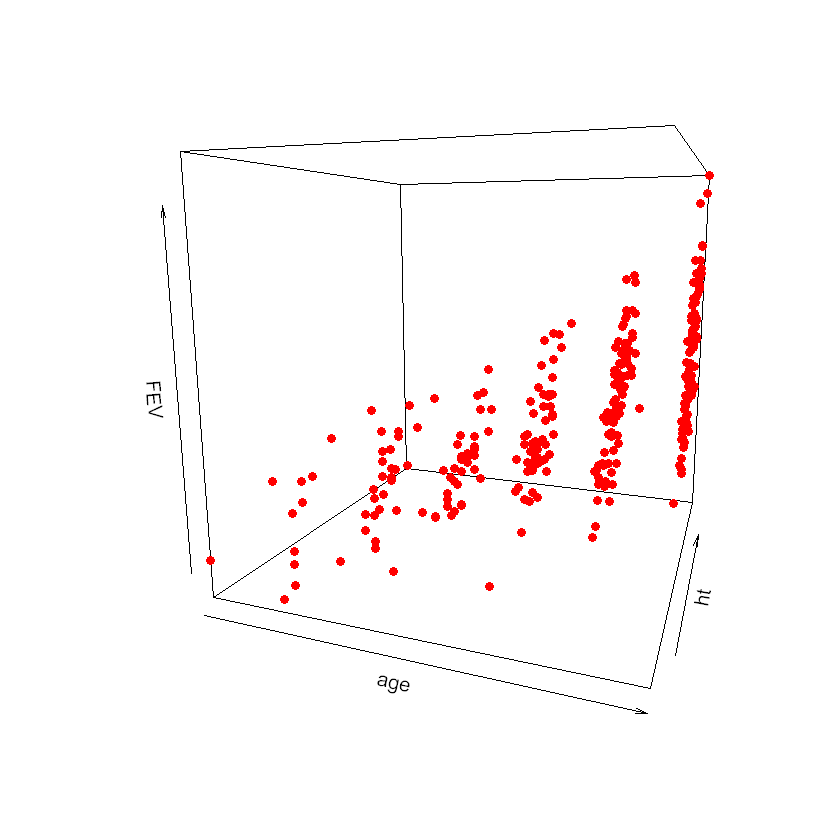

In [35]:
# z = lm(x + y)
x <- data_FEV_less_10$age
y <- data_FEV_less_10$ht
z <- data_FEV_less_10$FEV

grid.lines = 40
x.pred <- seq(min(x), max(x), length.out = grid.lines)
y.pred <- seq(min(y), max(y), length.out = grid.lines)
xy <- expand.grid( x = x.pred, y = y.pred)
z.pred <- matrix(predict(lmMod, newdata = xy), 
                 nrow = grid.lines, ncol = grid.lines)

# create the fitted points for droplines to the surface
fitpoints <- predict(lmMod)

# scatter plot with regression plane
scatter3D(x, y, z, pch = 19, cex = 1,colvar = NULL, col="red", 
          theta = 20, phi = 10, bty="b",xlab = "age",ylab = "ht", zlab = "FEV")

dev.off()

- FEV được dự đoán khá tốt qua age & ht

In [36]:
#done